In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../imports/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


## Panel H <br>
Data requirements: Patient HLA mutation status, MAF file

In [2]:
hla_df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/clinical/mutated_hla.csv', index_col=0)
hla_df.index = hla_df['Sample']

In [3]:
hla_df.groupby(['mutated_hla_in_maf', 'mutated_hla_in_shukla']).count()

Sample
mutated_hla_in_maf mutated_hla_in_shukla        
False              False                    8830
                   True                      114
True               False                     108
                   True                      124

In [4]:
# drop rows where maf is true and polysolver is false
hla_df = hla_df[~((hla_df.mutated_hla_in_maf == True)&(hla_df.mutated_hla_in_shukla == False))]

In [5]:
mutations_df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/tcga_mutation_file.csv', index_col=0)
mutations_df = mutations_df.drop_duplicates(['Barcode', 'Hugo_Symbol', 'Protein_position'])
mutations_df = mutations_df[mutations_df.Barcode.isin(hla_df['Sample'])]

In [6]:
tissues_df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/patient_tissues.csv', index_col=0)

In [7]:
df = pd.merge(tissues_df, pd.merge(pd.DataFrame(mutations_df.Barcode.value_counts()), hla_df, left_index=True, right_index=True),
                          left_index=True, right_index=True)
df.columns = ['Tissue', 'number_of_mutations', 'Sample', 'maf', 'polysolver']

In [8]:
tissues = list(df[df.polysolver == 1].Tissue.value_counts().index)[:10]

In [9]:
df[df.polysolver == 1].Tissue.value_counts()

HNSC    52
STAD    39
COAD    29
LUSC    21
LUAD    18
UCEC    18
SKCM    16
BLCA    13
BRCA     8
LGG      6
CESC     5
READ     4
KIRP     3
OV       2
KIRC     1
GBM      1
PRAD     1
THCA     1
Name: Tissue, dtype: int64

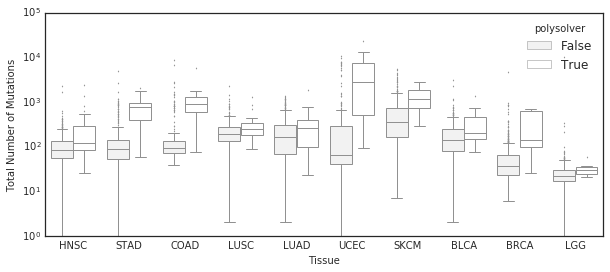

In [9]:
plt.rcParams['figure.figsize']=(10,4)
ax = sns.boxplot(x='Tissue', y='number_of_mutations', hue='polysolver', order=tissues, data=df, 
                 color='white', fliersize=1)
ax.set_yscale("log")
plt.ylabel('Total Number of Mutations')
plt.savefig('/cellar/users/ramarty/Data/hla/git_data/figures/hla_mutated.pdf')

In [10]:
# p-values
p = []
for tissue in tissues:
    tissue_df = df[df.Tissue == tissue]
    p.append(sp.mannwhitneyu(tissue_df[tissue_df.polysolver == True].number_of_mutations, tissue_df[tissue_df.polysolver == False].number_of_mutations)[1])
    print tissue, sp.mannwhitneyu(tissue_df[tissue_df.polysolver == True].number_of_mutations, tissue_df[tissue_df.polysolver == False].number_of_mutations)

HNSC MannwhitneyuResult(statistic=7760.5, pvalue=6.3575328157465001e-05)
STAD MannwhitneyuResult(statistic=1341.5, pvalue=1.9887860242886376e-17)
COAD MannwhitneyuResult(statistic=980.0, pvalue=2.5527380590930318e-13)
LUSC MannwhitneyuResult(statistic=3437.5, pvalue=0.013121713017642589)
LUAD MannwhitneyuResult(statistic=4084.5, pvalue=0.11574386402474013)
UCEC MannwhitneyuResult(statistic=549.0, pvalue=2.5852082485201965e-09)
SKCM MannwhitneyuResult(statistic=1343.0, pvalue=1.1504518358268601e-05)
BLCA MannwhitneyuResult(statistic=1654.5, pvalue=0.016584894870762375)
BRCA MannwhitneyuResult(statistic=1141.0, pvalue=0.00047231481681860428)
LGG MannwhitneyuResult(statistic=861.5, pvalue=0.036483442352682388)


In [11]:
df_pvalues = pd.DataFrame({'Tissue': tissues, 'Raw_p': p})

In [12]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
stats = importr('stats')

In [13]:
df_pvalues['BH_adj'] = stats.p_adjust(FloatVector(df_pvalues.Raw_p), method = 'BH')

In [14]:
df_pvalues

,Raw_p,Tissue,BH_adj
0,6.357533e-05,HNSC,1.271507e-04
1,1.988786e-17,STAD,1.988786e-16
2,2.552738e-13,COAD,1.276369e-12
3,1.312171e-02,LUSC,1.874530e-02
4,1.157439e-01,LUAD,1.157439e-01
5,2.585208e-09,UCEC,8.617361e-09
6,1.150452e-05,SKCM,2.876130e-05
7,1.658489e-02,BLCA,2.073112e-02
8,4.723148e-04,BRCA,7.871914e-04
9,3.648344e-02,LGG,4.053716e-02
